In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'    
os.environ['HF_HOME'] = '/data/amathur-23/DADA/transformers'

In [2]:
from utils.datasets import InTheWildDataset
from utils.metrics import ABXAccuracy
from utils.training import SpeechCLRTrainerVanilla
from utils.losses import TripletMarginCosineLoss

from models import SpeechEmbedder

import torch
import torch.nn as nn
from torch.nn.functional import cosine_similarity

2024-11-26 09:17:42.597386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732609062.860247 4042045 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732609062.933312 4042045 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 09:17:43.389046: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speec

In [3]:
from torch.utils.data import DataLoader
from utils.datasets import InTheWildDataset


train_dataset = InTheWildDataset(
        root_dir="/home/infres/amathur-23/DADA/datasets/InTheWild",
        metadata_file='meta.csv',
        include_spoofs=False,
        bonafide_label="bona-fide",
        filename_col="file",
        sampling_rate=16000,
        max_duration=4,
        split="train",
        config='configs/data/inthewild_toy.yaml',
        mode="triplet",
    )

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class AdaTriplet(nn.Module):
    """
    Adaptive Triplet Loss from
    Nyugen et al. 'AdaTriplet: Adaptive Gradient Triplet Loss with Automatic Margin Learning 
                   for Forensic Medical Image Matching'
    """

    def __init__(self, K_d=2, K_an=2, eps=0, beta=0, lambda_=1):
        super(AdaTriplet, self).__init__()
        self.K_d = K_d  
        self.K_an = K_an
        self.eps = eps
        self.beta = beta
        self.lambda_ = lambda_

        # stats, init?
        self.mu_d = 0
        self.mu_an = 0
        self.counter = 0

    def reset(self):
        self.mu_d = 0
        self.mu_an = 0
        self.counter = 0

    def update_stats(self, phi_ap, phi_an):
        delta = phi_ap - phi_an
        self.mu_d = (self.counter * self.mu_d + delta.mean()) / (self.counter + 1)
        self.mu_an = (self.counter * self.mu_an + phi_an.mean()) / (self.counter + 1)
        self.counter = self.counter + 1

    def update_margins(self):
        self.eps = self.mu_d / self.K_d
        self.beta = self.mu_an / self.K_an

    def __repr__(self):
        return f"AdaTriplet(K_d={self.K_d}, K_an={self.K_an}, eps={self.eps}, beta={self.beta}, lambda_={self.lambda_})"

    def forward(self, anchor, positive, negative):
        phi_ap = cosine_similarity(anchor, positive)
        phi_an = cosine_similarity(anchor, negative)

        with torch.no_grad():
            self.update_stats(phi_ap, phi_an)
            self.update_margins()

        loss = torch.clamp_min(phi_an - phi_ap + self.eps, 0) 
        loss = loss + self.lambda_ * torch.clamp_min(phi_an - self.beta, 0)
        loss = torch.mean(loss)
        return loss


In [6]:
criterion = AdaTriplet(K_d=2, K_an=2, eps=0, beta=0, lambda_=1)

In [7]:
criterion

AdaTriplet(K_d=2, K_an=2, eps=0, beta=0, lambda_=1)

In [9]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO

def fig2img(fig):
    buf = BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)
    return img

def get_tsne_fig(X, y, title):
    if X.shape[-1] > 50:
        X = PCA(n_components=50).fit_transform(X)
    X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(X)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(title)
    plt.legend(*scatter.legend_elements(), title="Labels")
    plt.close()
    return plt.gcf()

def get_tsne_img(X, y, title):
    fig = get_tsne_fig(X, y, title)
    img = fig2img(fig)
    return img

def plot_tsne(X, y, title):
    fig = get_tsne_fig(X, y, title)
    plt.show()



In [18]:
vis_dataset = InTheWildDataset(root_dir="/home/infres/amathur-23/DADA/datasets/InTheWild",
        metadata_file='meta.csv',
        include_spoofs=False,
        bonafide_label="bona-fide",
        filename_col="file",
        sampling_rate=16000,
        max_duration=4,
        split="train",
        config='configs/data/inthewild_toy.yaml',
        mode="classification",
        )

vis_loader = DataLoader(vis_dataset, batch_size=4, shuffle=True)

In [20]:
import numpy as np
from tqdm import tqdm

def visualise_clusters(epoch, split = 'val', n_samples=1000):
    if split == 'train':
        loader = train_loader
    elif split == 'val':
        loader = vis_loader
    model.eval()
    feats = []
    labels = []
    n_batches = n_samples // loader.batch_size
    with torch.no_grad():
        for i, input in tqdm(enumerate(loader)):
            # input = {k: v.to(device) for k, v in input.items()}
            input['x'] = input['x'].to(device)
            batch_feats = model(input, mode='classification')
            batch_labels = input['author']
            feats.append(batch_feats)
            labels.extend(batch_labels)
            if i >= n_batches:
                break
    feats = torch.cat(feats, dim=0).cpu().numpy()
    labels = np.array(labels)

    if feats.shape[-1] > 50:
        feats = PCA(n_components=50).fit_transform(feats)
    x_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(feats)
    authors = np.unique(labels)
    author_ids = np.arange(len(authors))
    author_id_map = dict(zip(authors, author_ids))
    label_ids = np.array([author_id_map[author] for author in labels])

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=label_ids, cmap='viridis')
    # plt.colorbar(scatter)
    plt.title(f"t-SNE at Epoch {epoch}")
    handles, _ = scatter.legend_elements()
    labels_unique = [authors[i] for i in np.unique(label_ids)]
    plt.legend(handles, labels_unique, title="Labels")

    plt.show()



/home/infres/amathur-23/DADA/dada/lib/python3.12/site-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
250it [00:04, 51.34it/s]


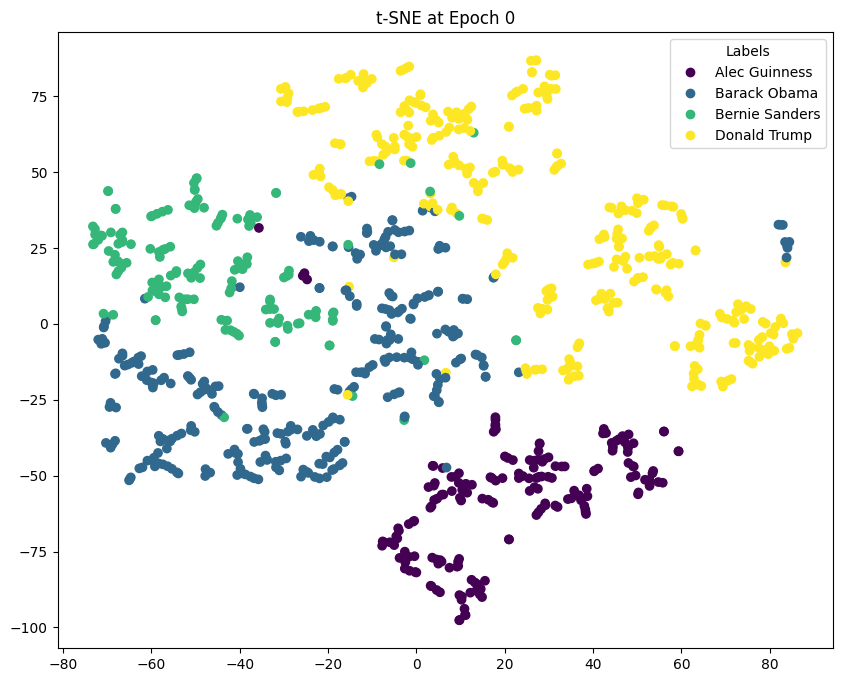

100%|██████████| 632/632 [01:44<00:00,  6.05it/s]


Epoch 1 Loss: 0.1319866180419922
TripletMarginCosineLoss()


250it [00:04, 52.59it/s]


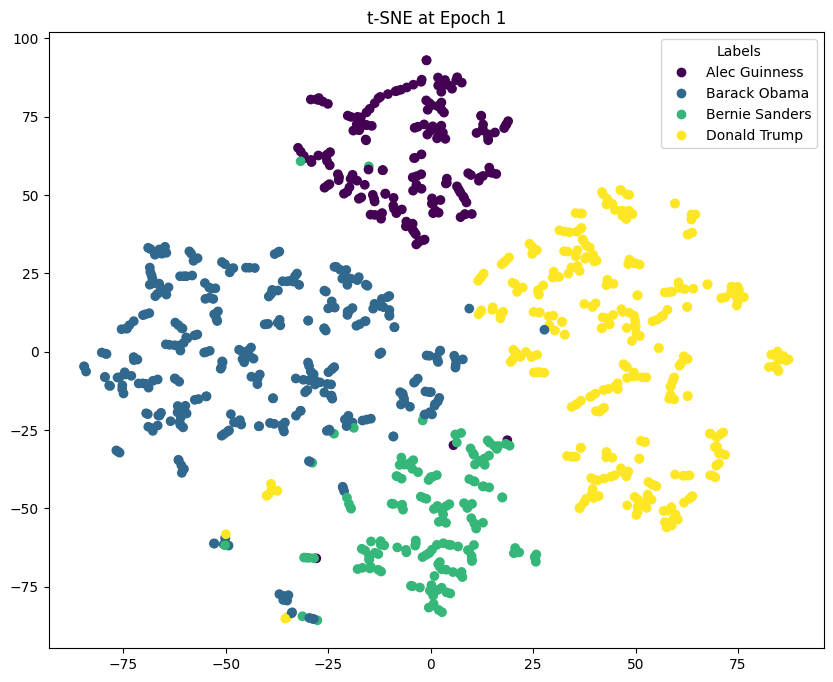

100%|██████████| 632/632 [01:44<00:00,  6.05it/s]


Epoch 2 Loss: 0.05976259335875511
TripletMarginCosineLoss()


250it [00:04, 52.42it/s]


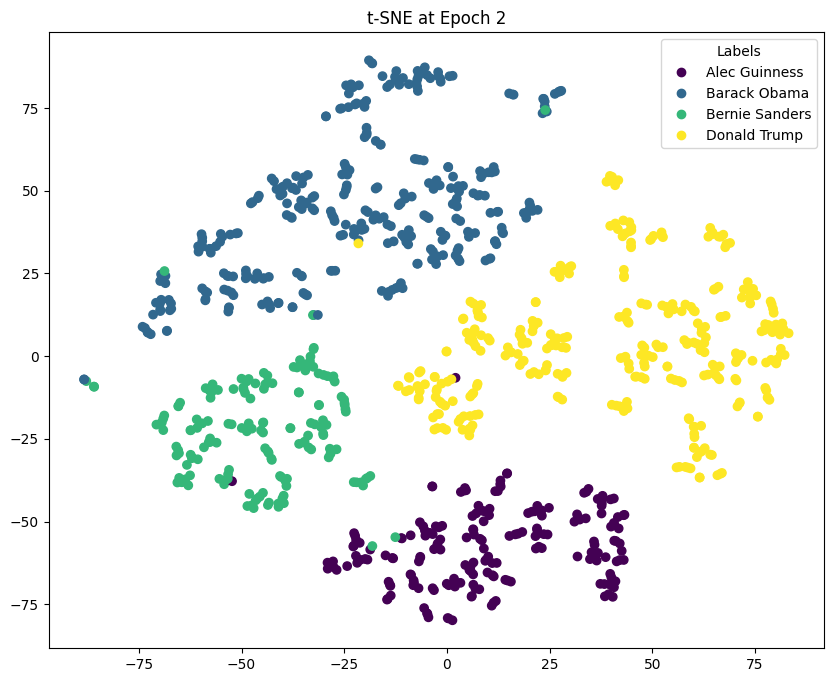

100%|██████████| 632/632 [01:44<00:00,  6.07it/s]


Epoch 3 Loss: 0.04226415231823921
TripletMarginCosineLoss()


250it [00:04, 52.02it/s]


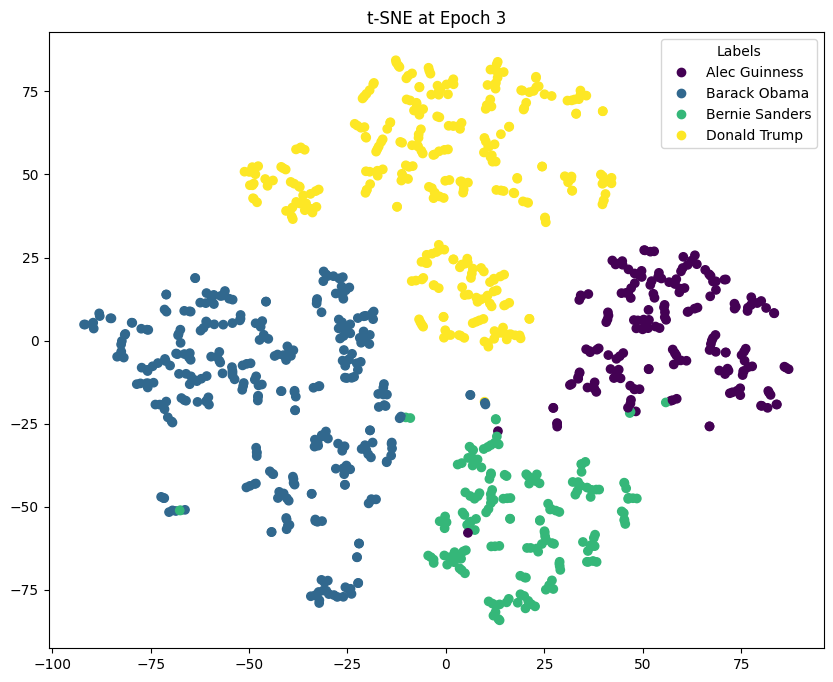

In [21]:
model = SpeechEmbedder().to(device)
criterion = TripletMarginCosineLoss(margin=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

visualise_clusters(0)
for e in range(3):
    for _ in tqdm(range(len(train_loader))):
        batch = next(iter(train_loader))

        optimizer.zero_grad()
        model.train()
        output = model(batch)
        loss = criterion(output["anchor"], output["positive"], output["negative"])
        loss.backward()
        optimizer.step()
    print(f"Epoch {e+1} Loss: {loss.item()}")
    print(criterion)
    visualise_clusters(e+1, 'val')

/home/infres/amathur-23/DADA/dada/lib/python3.12/site-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
250it [00:04, 51.78it/s]


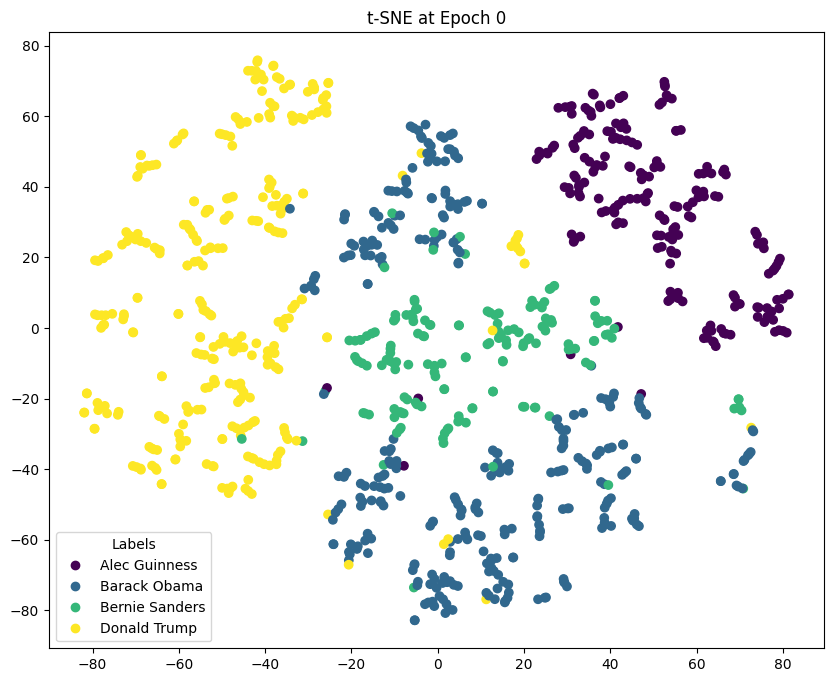

100%|██████████| 632/632 [01:44<00:00,  6.06it/s]


Epoch 1 Loss: 0.08967877924442291
AdaTriplet(K_d=2, K_an=2, eps=0.11652354896068573, beta=0.04785710945725441, lambda_=1)


250it [00:04, 52.25it/s]


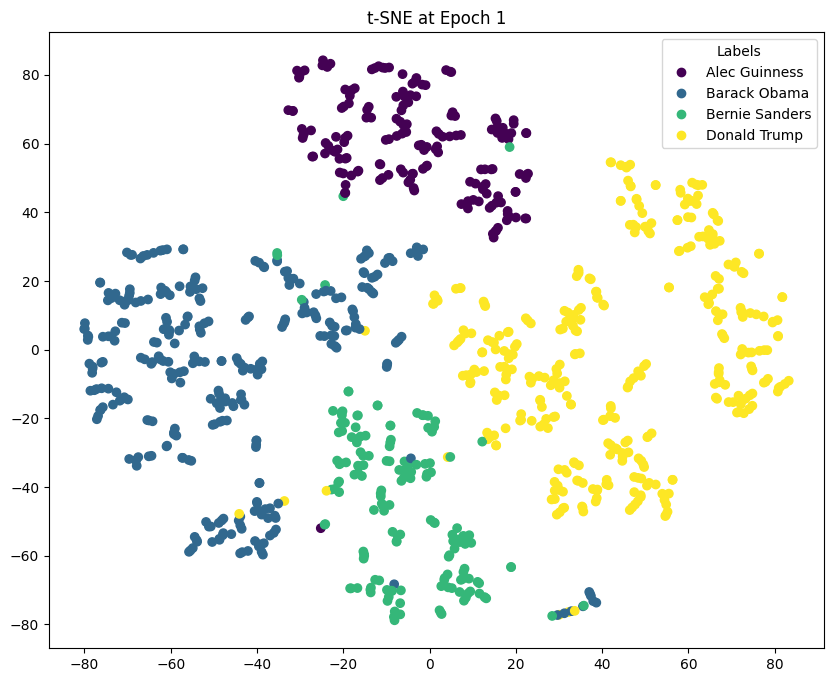

100%|██████████| 632/632 [01:44<00:00,  6.05it/s]


Epoch 2 Loss: 0.018085584044456482
AdaTriplet(K_d=2, K_an=2, eps=0.15133869647979736, beta=0.0011063229758292437, lambda_=1)


250it [00:04, 52.17it/s]


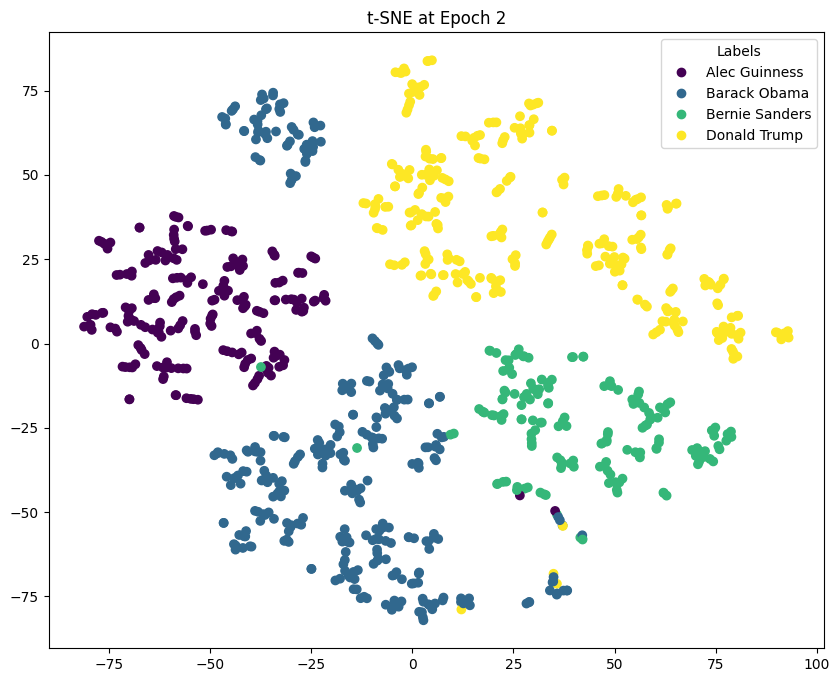

100%|██████████| 632/632 [01:44<00:00,  6.05it/s]


Epoch 3 Loss: 0.048802316188812256
AdaTriplet(K_d=2, K_an=2, eps=0.17801764607429504, beta=-0.018848096951842308, lambda_=1)


250it [00:04, 52.11it/s]


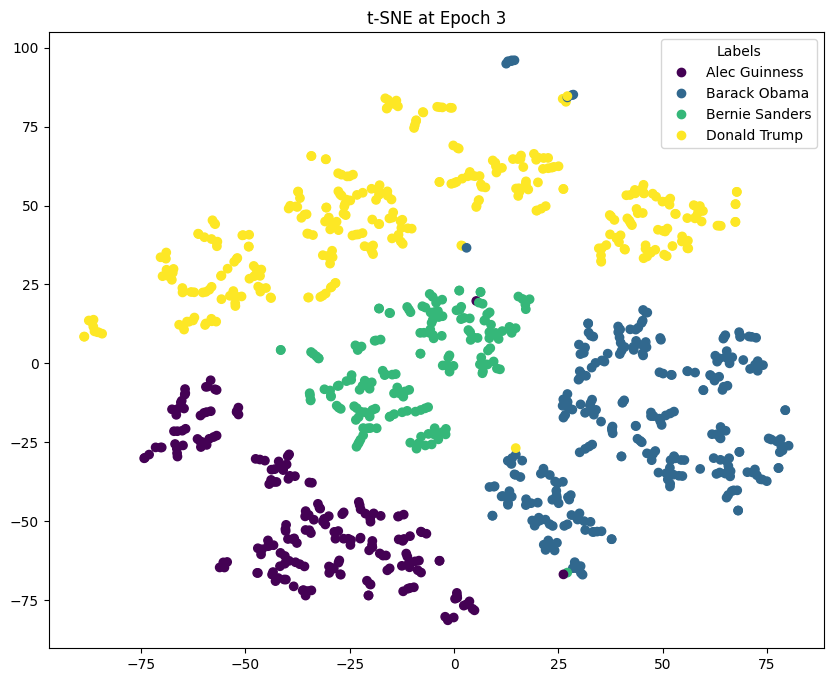

In [22]:
model = SpeechEmbedder().to(device)
criterion = AdaTriplet(K_d=2, K_an=2, eps=0, beta=0, lambda_=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

visualise_clusters(0)
for e in range(3):
    for _ in tqdm(range(len(train_loader))):
        batch = next(iter(train_loader))

        optimizer.zero_grad()
        model.train()
        output = model(batch)
        loss = criterion(output["anchor"], output["positive"], output["negative"])
        loss.backward()
        optimizer.step()
    print(f"Epoch {e+1} Loss: {loss.item()}")
    print(criterion)
    visualise_clusters(e+1, split='val')

In [23]:
from utils.metrics import ABXAccuracy
    